In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial.distance as distance
import sys

In [2]:
df = pd.read_csv("../data/movie_data.csv", delimiter=";")
df.head()

,budget,genres,imdb_id,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count
0,30000000.0,Animation,tt0114709,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1.0,1.0,1995-10-30,373554033.0,81.0,1.0,7.7,5415.0
1,65000000.0,Adventure,tt0113497,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,3.0,1.0,1995-12-15,262797249.0,104.0,2.0,6.9,2413.0
2,16000000.0,Comedy,tt0114885,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,1.0,1.0,1995-12-22,81452156.0,127.0,1.0,6.1,34.0
3,60000000.0,Action,tt0113277,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,3.0,1.0,1995-12-15,187436818.0,170.0,2.0,7.7,1886.0
4,35000000.0,Action,tt0114576,Sudden Death,International action superstar Jean Claude Van...,5.231580,3.0,1.0,1995-12-22,64350171.0,106.0,1.0,5.5,174.0


In [3]:
def data_preprocessing(df):
    var_df = df.select_dtypes(include='float64').dropna()

    scaler = StandardScaler()
    std_df = scaler.fit_transform(var_df)
    std_df = pd.DataFrame(data=std_df, columns=var_df.columns)

    return var_df, std_df

In [4]:
var_df, std_df = data_preprocessing(df)

In [5]:
var_df.head()

,budget,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_average,vote_count
0,30000000.0,21.946943,1.0,1.0,373554033.0,81.0,1.0,7.7,5415.0
1,65000000.0,17.015539,3.0,1.0,262797249.0,104.0,2.0,6.9,2413.0
2,16000000.0,3.859495,1.0,1.0,81452156.0,127.0,1.0,6.1,34.0
3,60000000.0,17.924927,3.0,1.0,187436818.0,170.0,2.0,7.7,1886.0
4,35000000.0,5.231580,3.0,1.0,64350171.0,106.0,1.0,5.5,174.0


In [6]:
std_df.head()

,budget,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_average,vote_count
0,-0.034670,2.128605,-0.886664,-0.463136,1.788698,-1.360726,-0.525049,1.566746,3.951587
1,0.854473,1.302755,0.036814,-0.463136,1.088086,-0.291382,0.553363,0.679210,1.423905
2,-0.390327,-0.900457,-0.886664,-0.463136,-0.059045,0.777963,-0.525049,-0.208327,-0.579211
3,0.727452,1.455048,0.036814,-0.463136,0.611380,2.777173,0.553363,1.566746,0.980171
4,0.092350,-0.670677,0.036814,-0.463136,-0.167226,-0.198395,-0.525049,-0.873979,-0.461332


In [7]:
std_df.shape

(5180, 9)

### Cluster Distance computation 

The class below enables the formation of distance/similarity matrix between the sample elements. Some methods of the class are used to compute distance based on certain criterion because after some iteration in Hierarchial clustering, we will have to compute distances between samples and clusters and between two clusters and so on. 

In [43]:
def _linkage(y, method='single', metric='euclidean', optimal_ordering=False):
    n = int(np.sqrt(2 * len(y) + 0.25) + 0.5)
    print(f"Number of observations n=({n})")

    # Initialize the distance matrix
    dist_matrix = np.zeros((n, n))

    # Create a 2D index array for the upper triangular part of the matrix
    i, j = np.triu_indices(n, k=1)

    # Assign values from the flattened array y to the upper triangular part of the matrix
    dist_matrix[i, j] = y

    # Initialize the clusters
    clusters = [{i} for i in range(n)]

    # Perform hierarchical clustering
    while len(clusters) > 1:
        min_dist = np.inf
        merge_indices = (0, 0)

        # Find the pair of clusters with the minimum distance
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                cluster_i = clusters[i]
                cluster_j = clusters[j]

                if method == 'single':
                    dist = np.min(dist_matrix[list(cluster_i)][:, list(cluster_j)])
                else:
                    raise ValueError(f"Unsupported linkage method: {method}")

                if dist < min_dist:
                    min_dist = dist
                    merge_indices = (i, j)

        # Merge the two clusters with the minimum distance
        merged_cluster = clusters[merge_indices[0]].union(clusters[merge_indices[1]])
        clusters.pop(merge_indices[1])
        clusters[merge_indices[0]] = merged_cluster

        # Update the distance matrix
        for i in range(len(clusters) - 1):
            for j in range(i + 1, len(clusters)):
                dist = np.min(dist_matrix[list(clusters[i])][:, list(clusters[j])])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist

    # Return the linkage matrix
    linkage_matrix = np.zeros((n - 1, 4))
    clusters = [i for i in clusters[0]]
    print(f"Clusters: {clusters}")
    print(f"Linkage matrix shape: {linkage_matrix.shape}")
    for i in range(n - 1):
        print(f"n={n}, i={i}, clusters[i]={clusters}, {list(clusters)[i]}")
        linkage_matrix[i, 0] = clusters[i]
        linkage_matrix[i, 1] = clusters[i]
        linkage_matrix[i, 2] = dist_matrix[i, i + 1]
        linkage_matrix[i, 3] = len(clusters) + 1

    return linkage_matrix

In [44]:
_linkage(y, method='single')

Number of observations n=(10)
Clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Linkage matrix shape: (9, 4)
n=10, i=0, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 0
n=10, i=1, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1
n=10, i=2, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 2
n=10, i=3, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 3
n=10, i=4, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 4
n=10, i=5, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 5
n=10, i=6, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 6
n=10, i=7, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 7
n=10, i=8, clusters[i]=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 8


array([[ 0.        ,  0.        ,  3.50708427, 11.        ],
       [ 1.        ,  1.        ,  2.48772035, 11.        ],
       [ 2.        ,  2.        ,  0.        , 11.        ],
       [ 3.        ,  3.        ,  3.21162649, 11.        ],
       [ 4.        ,  4.        ,  2.57374354, 11.        ],
       [ 5.        ,  5.        ,  2.57374354, 11.        ],
       [ 6.        ,  6.        ,  2.57374354, 11.        ],
       [ 7.        ,  7.        ,  2.57374354, 11.        ],
       [ 8.        ,  8.        ,  2.57374354, 11.        ]])

In [49]:
class LinkageUnionFind:
    """Structure for fast cluster labeling in an unsorted dendrogram."""

    def __init__(self, n):
        self.parent = np.arange(2 * n - 1, dtype=np.intc)
        self.next_label = n
        self.size = np.ones(2 * n - 1, dtype=np.intc)

    def merge(self, x, y):
        self.parent[x] = self.next_label
        self.parent[y] = self.next_label
        size = self.size[x] + self.size[y]
        self.size[self.next_label] = size
        self.next_label += 1
        return size

    def find(self, x):
        p = x

        while self.parent[x] != x:
            x = self.parent[x]

        while self.parent[p] != x:
            p, self.parent[p] = self.parent[p], x

        return x

In [50]:
def mst_single_linkage(dists, n):
    """Perform hierarchy clustering using MST algorithm for single linkage.

    Parameters
    ----------
    dists : ndarray
        A condensed matrix stores the pairwise distances of the observations.
    n : int
        The number of observations.

    Returns
    -------
    Z : ndarray, shape (n - 1, 4)
        Computed linkage matrix.
    """
    Z_arr = np.empty((n - 1, 4))
    Z = Z_arr

    # Which nodes were already merged.
    merged = np.zeros(n, dtype=np.intc)

    D = np.empty(n)
    D[:] = np.inf

    x, y = 0, 0

    for k in range(n - 1):
        current_min = np.inf
        merged[x] = 1

        for i in range(n):
            if merged[i] == 1:
                continue

            dist = dists[condensed_index(n, x, i)]
            if np.any(D[i] > dist):
                D[i] = dist
            if np.any(D[i] < current_min):
                y = i
                current_min = D[i]


        Z[k, 0] = x
        Z[k, 1] = y
        Z[k, 2] = current_min
        x = y

    # Sort Z by cluster distances.
    order = np.argsort(Z_arr[:, 2], kind='mergesort')
    Z_arr = Z_arr[order]

    # Find correct cluster labels and compute cluster sizes inplace.
    label(Z_arr, n)

    return Z_arr

def condensed_index(n, i, j):
    return n * j - j * (j + 1) // 2 + i - 1 - j

def label(Z, n):
    """Correctly label clusters in unsorted dendrogram."""
    uf = LinkageUnionFind(n)
    for i in range(n - 1):
        x, y = int(Z[i, 0]), int(Z[i, 1])
        x_root, y_root = uf.find(x), uf.find(y)
        if x_root < y_root:
            Z[i, 0], Z[i, 1] = x_root, y_root
        else:
            Z[i, 0], Z[i, 1] = y_root, x_root
        Z[i, 3] = uf.merge(x_root, y_root)

In [72]:
y = pdist(std_df[:10].to_numpy(), metric='euclidean')
y

array([3.50708427, 6.40069311, 5.51252144, 6.26997376, 5.27846246,
       5.74111177, 7.76718584, 6.52567695, 5.72625729, 3.9596786 ,
       3.26607158, 3.63169414, 2.48772035, 3.03846134, 5.21641204,
       4.35914641, 3.41469544, 4.34079308, 1.60017389, 3.89724451,
       1.71634131, 4.84234871, 3.99828762, 2.24837283, 4.85595882,
       3.11929207, 4.24901091, 5.78320169, 2.31625113, 3.21162649,
       4.02295399, 1.42263178, 4.44303878, 4.64231078, 2.94547455,
       3.5576732 , 4.2490328 , 3.88675449, 3.01859297, 4.4236242 ,
       4.1504596 , 2.4796497 , 4.89128916, 4.17300577, 2.57374354])

In [73]:
n = int(distance.num_obs_y(y))
n

10

In [75]:
Z = linkage(y, method='single')

In [76]:
_Z = mst_single_linkage(y, n)

In [77]:
Z

array([[ 4.        ,  6.        ,  1.42263178,  2.        ],
       [ 2.        , 10.        ,  1.60017389,  3.        ],
       [ 9.        , 11.        ,  2.24837283,  4.        ],
       [ 3.        ,  8.        ,  2.31625113,  2.        ],
       [ 1.        ,  5.        ,  2.48772035,  2.        ],
       [12.        , 13.        ,  2.57374354,  6.        ],
       [14.        , 15.        ,  3.01859297,  8.        ],
       [ 0.        , 16.        ,  3.50708427,  9.        ],
       [ 7.        , 17.        ,  4.17300577, 10.        ]])

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [45.0, 45.0, 62.5, 62.5],
  [85.0, 85.0, 95.0, 95.0],
  [53.75, 53.75, 90.0, 90.0],
  [30.0, 30.0, 71.875, 71.875],
  [15.0, 15.0, 50.9375, 50.9375],
  [5.0, 5.0, 32.96875, 32.96875]],
 'dcoord': [[0.0, 2.4877203546662408, 2.4877203546662408, 0.0],
  [0.0, 1.4226317812932971, 1.4226317812932971, 0.0],
  [0.0, 1.600173885956831, 1.600173885956831, 1.4226317812932971],
  [0.0, 2.248372833360869, 2.248372833360869, 1.600173885956831],
  [0.0, 2.316251125688489, 2.316251125688489, 0.0],
  [2.248372833360869,
   2.5737435386451217,
   2.5737435386451217,
   2.316251125688489],
  [2.4877203546662408,
   3.018592967058108,
   3.018592967058108,
   2.5737435386451217],
  [0.0, 3.507084267177062, 3.507084267177062, 3.018592967058108],
  [0.0, 4.1730057725645, 4.1730057725645, 3.507084267177062]],
 'ivl': ['7', '0', '1', '5', '9', '2', '4', '6', '3', '8'],
 'leaves': [7, 0, 1, 5, 9, 2, 4, 6, 3, 8],
 '

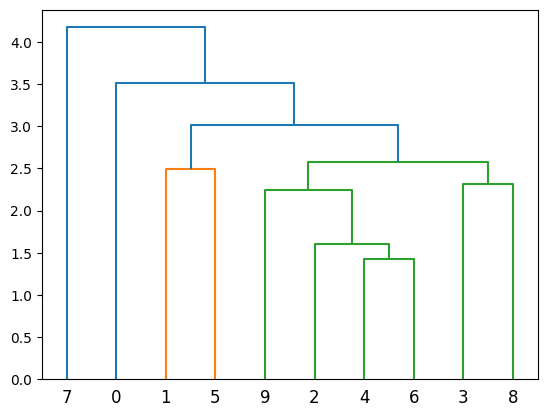

In [78]:
dendrogram(Z)

In [83]:
(_Z==Z)

array([[False, False,  True,  True],
       [False,  True,  True,  True],
       [False, False, False, False],
       [False, False,  True, False],
       [False, False, False,  True],
       [False, False, False, False],
       [False, False, False, False],
       [False,  True, False,  True],
       [ True,  True, False,  True]])

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [85.0, 85.0, 95.0, 95.0],
  [62.5, 62.5, 90.0, 90.0],
  [45.0, 45.0, 76.25, 76.25],
  [22.5, 22.5, 60.625, 60.625],
  [5.0, 5.0, 41.5625, 41.5625]],
 'dcoord': [[0.0, 2.479649696681071, 2.479649696681071, 0.0],
  [0.0, 2.479649696681071, 2.479649696681071, 2.479649696681071],
  [0.0, 1.4226317812932971, 1.4226317812932971, 0.0],
  [0.0, 1.600173885956831, 1.600173885956831, 1.4226317812932971],
  [0.0, 1.7163413051587895, 1.7163413051587895, 0.0],
  [1.600173885956831,
   2.316251125688489,
   2.316251125688489,
   1.7163413051587895],
  [0.0, 2.4877203546662408, 2.4877203546662408, 2.316251125688489],
  [2.479649696681071,
   2.945474548125137,
   2.945474548125137,
   2.4877203546662408],
  [0.0, 2.945474548125137, 2.945474548125137, 2.945474548125137]],
 'ivl': ['7', '9', '6', '8', '1', '4', '2', '5', '0', '3'],
 'leaves': [7, 9, 6, 8, 1, 4, 2, 5, 0, 3],
 'colo

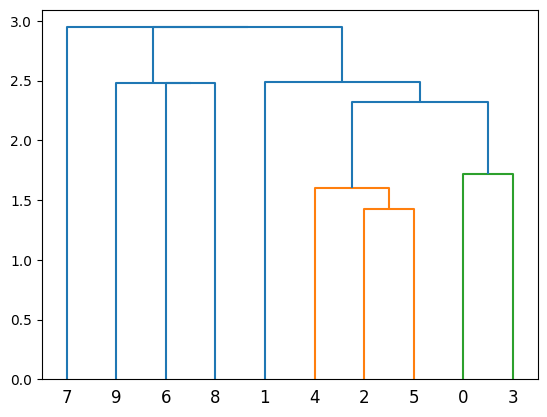

In [79]:
dendrogram(_Z)